# Imports

In [1]:
import ee
import numpy as np
import math
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#ee.Authenticate()


In [3]:

# Initialize Google Earth Engine
ee.Initialize()

In [4]:
# Load study area and community boundaries
nm_path = r"C:\Users\bsf31\Documents\data\NM\nm_vector.gpkg"
study_boundary = gpd.read_file(nm_path, layer='counties_dissolved')

silver_city_gdf = gpd.read_file(nm_path, layer='silver_city_qgis')


In [5]:
# Convert to Earth Engine geometry
ee_boundary = geemap.geopandas_to_ee(study_boundary)

ee_silver_city = geemap.geopandas_to_ee(silver_city_gdf).geometry()


In [6]:
ee_boundary_coordinates = ee_boundary.geometry()

# Landsat Collection 2

In [7]:
# Function to scale the surface temperature band and convert to Fahrenheit
def scale_lst(image):
    lst_k = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_f = lst_k.subtract(273.15).multiply(1.8).add(32)
    return image.addBands(lst_f.rename('LST_F'))

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])
    return image.addBands(ndvi.rename('NDVI'))

# Function to calculate Fraction of Vegetation Cover
def calculate_fvc(image):
    fvc = image.select('NDVI').subtract(0.2).divide(0.3).pow(2).clamp(0, 1)
    return image.addBands(fvc.rename('FVC'))

# Function to calculate Emissivity
def calculate_emissivity(image):
    emissivity = image.select('FVC').multiply(0.0004).add(0.986)
    return image.addBands(emissivity.rename('Emissivity'))

# Define a function to clip each image to the ROI
def clip_to_region(image,roi):
    return image.clip(roi)


In [8]:
pt = ee.Geometry.Point([-108.27, 32.78])   # Point corresponding to 


# Load the Landsat 8 collection and filter images based on criteria
landsat_collection1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate('2019-04-01', '2024-11-01') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover



In [9]:
""" pt = ee.Geometry.Point([-108.08, 32.46])   # Point corresponding to 

# Load the Landsat 8 collection and filter images based on criteria
landsat_collection1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate('2019-04-01', '2019-09-18') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover
# Load the Landsat 8 collection and filter images based on criteria
landsat_collection2 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate('2019-09-19', '2024-08-14') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover

# Load the Landsat 8 collection and filter images based on criteria
landsat_collection3 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate( '2024-08-15', '2024-11-01') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover """

' pt = ee.Geometry.Point([-108.08, 32.46])   # Point corresponding to \n\n# Load the Landsat 8 collection and filter images based on criteria\nlandsat_collection1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")     .filterDate(\'2019-04-01\', \'2019-09-18\')     .filter(ee.Filter.calendarRange(5, 9, \'month\'))     .filterBounds(pt)    .filter(ee.Filter.lt(\'CLOUD_COVER\', 9))  # Filter for images with less than 10% cloud cover\n# Load the Landsat 8 collection and filter images based on criteria\nlandsat_collection2 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")     .filterDate(\'2019-09-19\', \'2024-08-14\')     .filter(ee.Filter.calendarRange(5, 9, \'month\'))     .filterBounds(pt)    .filter(ee.Filter.lt(\'CLOUD_COVER\', 9))  # Filter for images with less than 10% cloud cover\n\n# Load the Landsat 8 collection and filter images based on criteria\nlandsat_collection3 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")     .filterDate( \'2024-08-15\', \'2024-11-01\')     .filter(ee.Filter.c

In [10]:
""" # Combine the collections
combined_collection = landsat_collection1.merge(landsat_collection2).merge(landsat_collection3)
# Get the list of image dates that meet the criteria
image_dates = combined_collection.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd')).getInfo()

print("Selected Image Dates:")
print(image_dates)
combined_collection
# Apply all processing steps
processed_collection = combined_collection \
    .map(lambda image: image.clip(ee_hurley)) \
    .map(scale_lst) \
    .map(calculate_ndvi) \
    .map(calculate_fvc) \
    .map(calculate_emissivity) 
 """

' # Combine the collections\ncombined_collection = landsat_collection1.merge(landsat_collection2).merge(landsat_collection3)\n# Get the list of image dates that meet the criteria\nimage_dates = combined_collection.aggregate_array(\'system:time_start\').map(lambda t: ee.Date(t).format(\'YYYY-MM-dd\')).getInfo()\n\nprint("Selected Image Dates:")\nprint(image_dates)\ncombined_collection\n# Apply all processing steps\nprocessed_collection = combined_collection     .map(lambda image: image.clip(ee_hurley))     .map(scale_lst)     .map(calculate_ndvi)     .map(calculate_fvc)     .map(calculate_emissivity) \n '

In [11]:
# Get the list of image dates that meet the criteria
image_dates = landsat_collection1.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd')).getInfo()

print("Selected Image Dates:")
print(image_dates)



Selected Image Dates:
['2019-05-29', '2019-06-30', '2019-08-01', '2019-09-02', '2019-09-18', '2020-05-15', '2020-05-31', '2020-06-16', '2020-08-03', '2020-08-19', '2020-09-04', '2020-09-20', '2021-05-02', '2021-06-03', '2021-06-19', '2021-07-21', '2021-08-06', '2021-08-22', '2021-09-07', '2022-05-05', '2022-05-21', '2022-06-06', '2022-07-08', '2022-09-10', '2023-05-08', '2023-05-24', '2023-06-25', '2023-07-27', '2023-09-29', '2024-05-10', '2024-05-26', '2024-06-11', '2024-07-13', '2024-08-14', '2024-08-30']


In [12]:

# Apply all processing steps
processed_collection = landsat_collection1 \
    .map(lambda image: image.clip(ee_silver_city)) \
    .map(scale_lst) \
    .map(calculate_ndvi) \
    .map(calculate_fvc) \
    .map(calculate_emissivity) 

In [13]:
processed_collection

In [23]:
# Function to extract LST values
def extract_lst(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    mean_lst = image.select('LST_F').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee_silver_city,
        scale=30
    ).get('LST_F')
    return ee.Feature(None, {'date': date, 'LST': mean_lst})

# Extract LST values
lst_values = processed_collection.map(extract_lst)


In [15]:
""" # Function to extract LST values and handle missing values
def extract_lst(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    
    # Compute mean LST
    mean_lst = image.select('LST_F').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee_silver_city,
        scale=30,
        maxPixels=1e8,
        bestEffort=True
    ).get('LST_F')
    
    # Check if LST is null (empty) and add a flag
    lst_flag = ee.Algorithms.If(mean_lst, 1, 0)  # 1 if LST exists, 0 otherwise
    
    return ee.Feature(None, {'date': date, 'LST': mean_lst, 'valid': lst_flag})


# Extract LST values
lst_values = processed_collection.map(extract_lst)
# Count valid LST values
valid_count = lst_values.aggregate_sum('valid').getInfo()
print(f"\nValid LST values extracted: {valid_count} out of {processed_collection.size().getInfo()}") """


Valid LST values extracted: 35 out of 35


In [24]:
lst_values.getInfo()

In [25]:
# Print results
print("Date, Mean LST (°F)")
lst_list = lst_values.getInfo().get('features')
for feature in lst_list:
    date = feature['properties']['date']
    lst = feature['properties']['LST']
    print(f"{date}, {lst:.2f}")

Date, Mean LST (°F)
2019-05-29, 107.44
2019-06-30, 124.21
2019-08-01, 108.00
2019-09-02, 111.81
2019-09-18, 93.54
2020-05-15, 109.38
2020-05-31, 115.52
2020-06-16, 110.29
2020-08-03, 123.70
2020-08-19, 119.82
2020-09-04, 116.42
2020-09-20, 102.81
2021-05-02, 103.75
2021-06-03, 121.71
2021-06-19, 134.94
2021-07-21, 114.65
2021-08-06, 109.25
2021-08-22, 103.72
2021-09-07, 104.72
2022-05-05, 108.73
2022-05-21, 113.92
2022-06-06, 122.85
2022-07-08, 119.16
2022-09-10, 105.88
2023-05-08, 109.76
2023-05-24, 110.14
2023-06-25, 124.03
2023-07-27, 134.14
2023-09-29, 103.58
2024-05-10, 105.32
2024-05-26, 111.61
2024-06-11, 123.28
2024-07-13, 115.31
2024-08-14, 109.73
2024-08-30, 98.51


In [ ]:
""" # Print results safely, skipping missing values
print("Date, Mean LST (°F)")
lst_list = lst_values.getInfo().get('features')

for feature in lst_list:
    date = feature['properties']['date']
    lst = feature['properties'].get('LST', None)  # Avoid KeyError by using .get()
    
    if lst is not None:
        print(f"{date}, {lst:.2f}")
    else:
        print(f"{date}, MISSING") """

In [19]:


# Print collection information
print(f"\nNumber of images: {processed_collection.size().getInfo()}")
#print(f"Date range: {start_date} to {end_date}")

# Print cloud cover information
cloud_covers = processed_collection.aggregate_array('CLOUD_COVER').getInfo()
dates = processed_collection.aggregate_array('system:time_start').getInfo()
dates = [ee.Date(d).format('YYYY-MM-dd').getInfo() for d in dates]

print("\nCloud cover for each image:")
for date, cloud_cover in zip(dates, cloud_covers):
    print(f"{date}: {cloud_cover:.2f}%")


Number of images: 35

Cloud cover for each image:
2019-05-29: 7.42%
2019-06-30: 7.17%
2019-08-01: 7.59%
2019-09-02: 4.46%
2019-09-18: 7.68%
2020-05-15: 0.03%
2020-05-31: 2.03%
2020-06-16: 4.03%
2020-08-03: 0.02%
2020-08-19: 0.34%
2020-09-04: 0.61%
2020-09-20: 0.43%
2021-05-02: 0.06%
2021-06-03: 5.08%
2021-06-19: 0.91%
2021-07-21: 7.28%
2021-08-06: 4.96%
2021-08-22: 7.42%
2021-09-07: 0.00%
2022-05-05: 0.01%
2022-05-21: 0.06%
2022-06-06: 0.01%
2022-07-08: 3.63%
2022-09-10: 3.26%
2023-05-08: 0.02%
2023-05-24: 0.14%
2023-06-25: 0.04%
2023-07-27: 3.43%
2023-09-29: 0.24%
2024-05-10: 8.20%
2024-05-26: 0.06%
2024-06-11: 3.74%
2024-07-13: 0.65%
2024-08-14: 8.54%
2024-08-30: 7.45%


In [20]:
""" ## Define the specific dates you want to inspect
specific_dates = ['2019-09-18', '2024-08-14']  # Replace with your desired dates

# Filter the collection for specific dates using ee.Filter.Or
filtered_collection = processed_collection.filter(
    ee.Filter.Or(
        ee.Filter.date(specific_dates[0], ee.Date(specific_dates[0]).advance(1, 'day')),
        ee.Filter.date(specific_dates[1], ee.Date(specific_dates[1]).advance(1, 'day'))
    )
)

# Check if the collection is empty
if filtered_collection.size().getInfo() == 0:
    raise ValueError("No images found for the specified dates.")

# Create the map and add true-color layers for the specific dates
Map = geemap.Map()
Map.center_object(ee_hurley, 12)

# Visualization parameters for true-color composite
true_color_vis_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # Red, Green, Blue
    'min': 0,
    'max': 3000,  # Adjust based on the reflectance range of your data
    'gamma': 1.4  # Optional: adjust for better visualization
}

# Add true-color layers for each date
filtered_images = filtered_collection.toList(filtered_collection.size())
for i in range(filtered_collection.size().getInfo()):
    image = ee.Image(filtered_images.get(i))
    image_date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    Map.addLayer(image, true_color_vis_params, f'True Color {image_date}')

Map.addLayer(ee_hurley, {}, 'Hurley Boundary')
Map """




' ## Define the specific dates you want to inspect\nspecific_dates = [\'2019-09-18\', \'2024-08-14\']  # Replace with your desired dates\n\n# Filter the collection for specific dates using ee.Filter.Or\nfiltered_collection = processed_collection.filter(\n    ee.Filter.Or(\n        ee.Filter.date(specific_dates[0], ee.Date(specific_dates[0]).advance(1, \'day\')),\n        ee.Filter.date(specific_dates[1], ee.Date(specific_dates[1]).advance(1, \'day\'))\n    )\n)\n\n# Check if the collection is empty\nif filtered_collection.size().getInfo() == 0:\n    raise ValueError("No images found for the specified dates.")\n\n# Create the map and add true-color layers for the specific dates\nMap = geemap.Map()\nMap.center_object(ee_hurley, 12)\n\n# Visualization parameters for true-color composite\ntrue_color_vis_params = {\n    \'bands\': [\'SR_B4\', \'SR_B3\', \'SR_B2\'],  # Red, Green, Blue\n    \'min\': 0,\n    \'max\': 3000,  # Adjust based on the reflectance range of your data\n    \'gamma\': 

In [26]:
# Calculate the mean image across the entire collection
collection_mean = processed_collection.mean()

# Extract the mean LST over the Hurley area
mean_lst = collection_mean.select('LST_F').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_silver_city,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).get('LST_F')

# Get the result as a Python object
mean_lst_value = mean_lst.getInfo()

print("Mean LST (°F) for the entire collection over Hurley, NM:", mean_lst_value)


Mean LST (°F) for the entire collection over Hurley, NM: 112.9043206508221


In [27]:
# Set up export parameters
export_task = ee.batch.Export.image.toDrive(
    image=collection_mean.select('LST_F'),  # Select the LST band
    description='Silver_City_LST_Mean',
    folder='lst',  # Optional: specify a folder in Google Drive
    fileNamePrefix='Silver_City_LST_Mean_Image',
    region=ee_silver_city,
    scale=30,
    crs='EPSG:4326',  # 'EPSG:32612',  # Use UTM Zone 12N to match the Hurley vectors
    maxPixels=1e13
)

# Start the export task
export_task.start()
print("Exporting mean LST image to Google Drive...")

Exporting mean LST image to Google Drive...


In [31]:
vis_params = {'bands': ['SR_B1'], 'palette': ['#0b0000', '#0d0000', '#100000', '#120000', '#150000', '#180000', '#1a0000', '#1d0000', '#200000', '#220000', '#250000', '#270000', '#2a0000', '#2d0000', '#2f0000', '#320000', '#350000', '#370000', '#3a0000', '#3c0000', '#3f0000', '#420000', '#440000', '#470000', '#4a0000', '#4c0000', '#4f0000', '#510000', '#540000', '#570000', '#590000', '#5c0000', '#5f0000', '#610000', '#640000', '#660000', '#690000', '#6c0000', '#6e0000', '#710000', '#740000', '#760000', '#790000', '#7b0000', '#7e0000', '#810000', '#830000', '#860000', '#890000', '#8b0000', '#8e0000', '#900000', '#930000', '#960000', '#980000', '#9b0000', '#9e0000', '#a00000', '#a30000', '#a50000', '#a80000', '#ab0000', '#ad0000', '#b00000', '#b30000', '#b50000', '#b80000', '#ba0000', '#bd0000', '#c00000', '#c20000', '#c50000', '#c80000', '#ca0000', '#cd0000', '#cf0000', '#d20000', '#d50000', '#d70000', '#da0000', '#dd0000', '#df0000', '#e20000', '#e40000', '#e70000', '#ea0000', '#ec0000', '#ef0000', '#f20000', '#f40000', '#f70000', '#f90000', '#fc0000', '#ff0000', '#ff0200', '#ff0500', '#ff0800', '#ff0a00', '#ff0d00', '#ff1000', '#ff1200', '#ff1500', '#ff1700', '#ff1a00', '#ff1d00', '#ff1f00', '#ff2200', '#ff2500', '#ff2700', '#ff2a00', '#ff2c00', '#ff2f00', '#ff3200', '#ff3400', '#ff3700', '#ff3a00', '#ff3c00', '#ff3f00', '#ff4100', '#ff4400', '#ff4700', '#ff4900', '#ff4c00', '#ff4f00', '#ff5100', '#ff5400', '#ff5600', '#ff5900', '#ff5c00', '#ff5e00', '#ff6100', '#ff6400', '#ff6600', '#ff6900', '#ff6b00', '#ff6e00', '#ff7100', '#ff7300', '#ff7600', '#ff7900', '#ff7b00', '#ff7e00', '#ff8000', '#ff8300', '#ff8600', '#ff8800', '#ff8b00', '#ff8e00', '#ff9000', '#ff9300', '#ff9500', '#ff9800', '#ff9b00', '#ff9d00', '#ffa000', '#ffa200', '#ffa500', '#ffa800', '#ffaa00', '#ffad00', '#ffb000', '#ffb200', '#ffb500', '#ffb700', '#ffba00', '#ffbd00', '#ffbf00', '#ffc200', '#ffc500', '#ffc700', '#ffca00', '#ffcc00', '#ffcf00', '#ffd200', '#ffd400', '#ffd700', '#ffda00', '#ffdc00', '#ffdf00', '#ffe100', '#ffe400', '#ffe700', '#ffe900', '#ffec00', '#ffef00', '#fff100', '#fff400', '#fff600', '#fff900', '#fffc00', '#fffe00', '#ffff03', '#ffff07', '#ffff0b', '#ffff0f', '#ffff13', '#ffff17', '#ffff1b', '#ffff1f', '#ffff22', '#ffff26', '#ffff2a', '#ffff2e', '#ffff32', '#ffff36', '#ffff3a', '#ffff3e', '#ffff42', '#ffff46', '#ffff4a', '#ffff4e', '#ffff52', '#ffff56', '#ffff5a', '#ffff5e', '#ffff61', '#ffff65', '#ffff69', '#ffff6d', '#ffff71', '#ffff75', '#ffff79', '#ffff7d', '#ffff81', '#ffff85', '#ffff89', '#ffff8d', '#ffff91', '#ffff95', '#ffff99', '#ffff9d', '#ffffa0', '#ffffa4', '#ffffa8', '#ffffac', '#ffffb0', '#ffffb4', '#ffffb8', '#ffffbc', '#ffffc0', '#ffffc4', '#ffffc8', '#ffffcc', '#ffffd0', '#ffffd4', '#ffffd8', '#ffffdc', '#ffffdf', '#ffffe3', '#ffffe7', '#ffffeb', '#ffffef', '#fffff3', '#fffff7', '#fffffb', '#ffffff'], 'min': 8937.828571428572, 'max': 14637.171428571428}

Map = geemap.Map()
Map.center_object(ee_silver_city, 12)
Map.addLayer(collection_mean, vis_params, 'collection_mean')
Map


Map(center=[32.78946800998195, -108.27030955522709], controls=(WidgetControl(options=['position', 'transparent…

In [35]:
# Function to calculate per-image statistics for LST
def calculate_stats_per_image(image):
    stats = image.select('LST_F').reduceRegion(
        reducer=ee.Reducer.mean()
            .combine(ee.Reducer.min(), sharedInputs=True)
            .combine(ee.Reducer.max(), sharedInputs=True)
            .combine(ee.Reducer.stdDev(), sharedInputs=True),
        geometry=ee_silver_city,
        scale=30,
        maxPixels=1e8,
        bestEffort=True
    )
    return image.set(stats)

In [32]:
""" def calculate_stats_per_image(image):
    stats = image.select('LST_F').reduceRegion(
        reducer=ee.Reducer.mean()
            .combine(ee.Reducer.min(), sharedInputs=True)
            .combine(ee.Reducer.max(), sharedInputs=True)
            .combine(ee.Reducer.stdDev(), sharedInputs=True),
        geometry=ee_silver_city,
        scale=30,
        maxPixels=1e8,
        bestEffort=True
    )
    
    # Check if stats are missing
    valid = stats.contains('LST_F')
    
    return image.set(stats).set({'valid': valid}) """


In [36]:
# Apply the function to each image in the collection to get per-image statistics
stats_per_image = processed_collection.map(calculate_stats_per_image)

In [ ]:
""" valid_stats_count = stats_per_image.aggregate_sum('valid').getInfo()
print(f"\nValid per-image statistics extracted: {valid_stats_count} out of {processed_collection.size().getInfo()}") """


In [38]:
# Extract individual statistics
dates = stats_per_image.aggregate_array('system:time_start').getInfo()
means = stats_per_image.aggregate_array('LST_F_mean').getInfo()
mins = stats_per_image.aggregate_array('LST_F_min').getInfo()
maxs = stats_per_image.aggregate_array('LST_F_max').getInfo()
std_devs = stats_per_image.aggregate_array('LST_F_stdDev').getInfo()


In [39]:
# Print per-image statistics
print("Per-image LST statistics:")
for date, mean, min_, max_, std_dev in zip(dates, means, mins, maxs, std_devs):
    formatted_date = ee.Date(date).format("YYYY-MM-dd").getInfo()
    print(f"Date: {formatted_date}, Mean LST: {mean}, Min LST: {min_}, Max LST: {max_}, StdDev LST: {std_dev}")

Per-image LST statistics:
Date: 2019-05-29, Mean LST: 107.4442826098656, Min LST: 92.907896792, Max LST: 118.18210388000001, StdDev LST: 3.657930218955513
Date: 2019-06-30, Mean LST: 124.20624806924556, Min LST: 108.75041949199999, Max LST: 135.31663814000007, StdDev LST: 3.4601602319195486
Date: 2019-08-01, Mean LST: 108.00379542894692, Min LST: 59.586303416000035, Max LST: 120.30469429999997, StdDev LST: 5.578359069308231
Date: 2019-09-02, Mean LST: 111.80885668077158, Min LST: 94.49522528, Max LST: 123.75621089600007, StdDev LST: 4.1393718623595674
Date: 2019-09-18, Mean LST: 93.54411417780041, Min LST: 53.987586656000104, Max LST: 110.66997952400011, StdDev LST: 8.446809441343083
Date: 2020-05-15, Mean LST: 109.37858105714507, Min LST: 96.42709018400001, Max LST: 121.32599867600008, StdDev LST: 3.496407894132101
Date: 2020-05-31, Mean LST: 115.52349747812063, Min LST: 102.05041668800003, Max LST: 125.52196002800001, StdDev LST: 3.0862260725390875
Date: 2020-06-16, Mean LST: 110.292

In [40]:
# Calculate overall statistics for the entire collection (min, max, stdDev)
collection_min = processed_collection.select('LST_F').reduce(ee.Reducer.min()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_silver_city,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).getInfo()

collection_max = processed_collection.select('LST_F').reduce(ee.Reducer.max()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_silver_city,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).getInfo()

collection_stddev = processed_collection.select('LST_F').reduce(ee.Reducer.stdDev()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_silver_city,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).getInfo()

# Print overall statistics
print("\nOverall Collection Statistics:")
print(f"Min LST: {collection_min}")
print(f"Max LST: {collection_max}")
print(f"StdDev LST: {collection_stddev}")


Overall Collection Statistics:
Min LST: {'LST_F_min': 90.34954365631643}
Max LST: {'LST_F_max': 135.50139294700983}
StdDev LST: {'LST_F_stdDev': 9.66952732669877}


Per-Image Standard Deviation: For each image, the standard deviation shows the variability of LST across the Hurley area at a specific time. A low standard deviation means the temperatures are relatively uniform across the region, while a high standard deviation suggests there are large differences in temperature within that image, perhaps due to mixed land covers or varying microclimates.

Overall Collection Standard Deviation: When calculated across the entire collection, the standard deviation reflects how much the mean LST changes over time. A low value indicates that the temperatures are fairly stable across the whole period, while a high standard deviation suggests significant temperature changes over time, such as seasonal variations or extreme weather events.

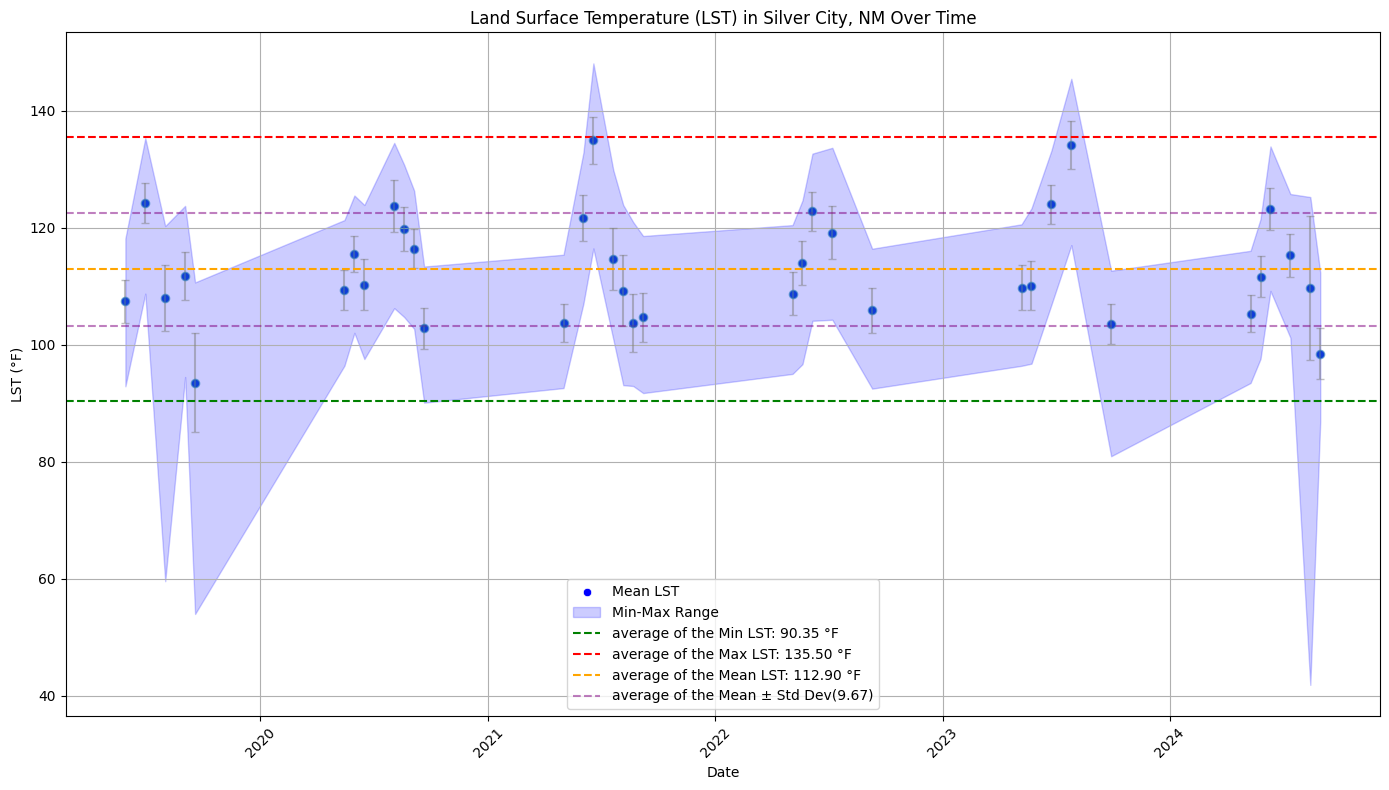

In [41]:
# Create the DataFrame
data = {
    'Date': [ee.Date(date).format("YYYY-MM-dd").getInfo() for date in dates],
    'Mean_LST': means,
    'Min_LST': mins,
    'Max_LST': maxs,
    'StdDev_LST': std_devs
}
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Overall collection statistics
overall_min = 90.35
overall_max =  135.50  
overall_std_dev = 9.67
overall_mean =  112.90

# Set up the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Date', y='Mean_LST', data=df, color='blue', label='Mean LST')

# Add error bars for standard deviation
plt.errorbar(df['Date'], df['Mean_LST'], yerr=df['StdDev_LST'], fmt='o', ecolor='gray', alpha=0.5, capsize=3)

# Add shaded area for Min-Max range
plt.fill_between(df['Date'], df['Min_LST'], df['Max_LST'], color='blue', alpha=0.2, label='Min-Max Range')

# Add overall statistics as horizontal lines
plt.axhline(overall_min, color='green', linestyle='--', label=f'average of the Min LST: {overall_min:.2f} °F')
plt.axhline(overall_max, color='red', linestyle='--', label=f'average of the Max LST: {overall_max:.2f} °F')
plt.axhline(overall_mean, color='orange', linestyle='--', label=f'average of the Mean LST: {overall_mean:.2f} °F')
plt.axhline(overall_mean + overall_std_dev, color='purple', linestyle='--', alpha=0.5, label=f'average of the Mean ± Std Dev({overall_std_dev})')
plt.axhline(overall_mean - overall_std_dev, color='purple', linestyle='--', alpha=0.5)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('LST (°F)')
plt.title('Land Surface Temperature (LST) in Silver City, NM Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
""" # Compute the long-term baseline (mean of all images in the collection)
baseline = processed_collection.mean()

# Function to calculate the anomaly for each image
def calculate_anomaly(image):
    anomaly = image.select('LST_F').subtract(baseline.select('LST_F'))  # Subtract baseline pixel by pixel
    return image.addBands(anomaly.rename('LST_Anomaly'))  # Add anomaly as a new band

# Map the anomaly calculation across the processed collection
anomaly_collection = processed_collection.map(calculate_anomaly)

# Visualization parameters for anomalies
anomaly_vis_params = {
    'min': -20,  # Adjust based on expected range of anomalies
    'max': 20,
    'palette': ['blue', 'white', 'red'],  # Blue for cooler, red for warmer
}

# Add the mean anomaly layer to the map
Map = geemap.Map()
Map.center_object(ee_hurley, 12)

# Visualize mean anomaly across the collection
mean_anomaly = anomaly_collection.select('LST_Anomaly').mean()
Map.addLayer(mean_anomaly, anomaly_vis_params, 'Mean Temperature Anomaly')
Map.addLayer(ee_hurley, {}, 'Hurley Boundary')
Map
 """

In [ ]:
""" # Set up export parameters
export_task = ee.batch.Export.image.toDrive(
    image=mean_anomaly.select('LST_Anomaly'),  # Select the LST band
    description='Hurley_LST_Anomaly',
    folder='lst',  # Optional: specify a folder in Google Drive
    fileNamePrefix='Hurley_LST_Anomaly',
    region=ee_hurley,
    scale=30,
    crs='EPSG:4326',  # 'EPSG:32612',  # Use UTM Zone 12N to match the Hurley vectors
    maxPixels=1e13
)

# Start the export task
export_task.start()
print("Exporting LST_Anomaly to Google Drive...") """

Hurley Area

In [ ]:
(1874540.995237139 + 385529.09372809314)

In [ ]:
2260070.088965232/4046.85642

In [ ]:
558.4754818074895

SC AREA

In [ ]:
2787514.188/4046.85642

Lordsburg Area

In [ ]:
4747221.320008123/4046.85642